In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

numpy = lambda x : x.detach().cpu().squeeze().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
path = '../data/'

# nameA = 'sawtooth'
# nameB = 'checkerboard'

nameA = 'reptil_skin'
nameB = 'metal'


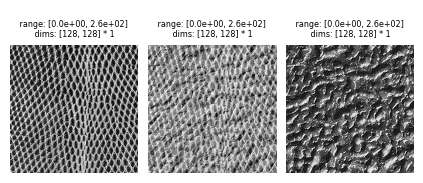

In [14]:
imageA = plt.imread(path + nameA + '.pgm').astype(float)
imageB = plt.imread(path + nameB + '.pgm').astype(float)

imageA = pt.blurDn(imageA, 1, 'qmf9')
imageB = pt.blurDn(imageB, 1, 'qmf9')

imageA = po.rescale(imageA, 0, 255)
imageB = po.rescale(imageB, 0, 255)

imgSize = imageA.shape[0]
pt.imshow([imageA, po.rescale(imageA - imageB, 0, 255), imageB], vrange='auto1');

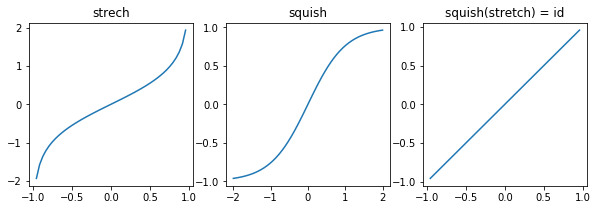

In [15]:
# explaining the non-linearity

xs = np.linspace(-1,1)
xs = xs[1:-1]
ys = np.log(( 1 + xs ) / ( 1 - xs )) / 2

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title('strech')
plt.plot(xs, ys)
plt.subplot(1,3,2)
plt.title('squish')
plt.plot(np.linspace(-2,2), np.tanh(np.linspace(-2,2)))
plt.subplot(1,3,3)
plt.title('squish(stretch) = id')
plt.plot(xs, np.tanh(ys))
plt.show()


In [23]:
imgA = torch.tensor(imageA, dtype=dtype)
imgB = torch.tensor(imageB, dtype=dtype)

model = po.simul.Front_End()
# model = po.simul.Linear(kernel_size=(25, 25))
# model = po.simul.Linear_Nonlinear(kernel_size=(5, 5))
# model = po.simul.Steerable_GainControl(imageA.shape)

# model = po.simul.Steerable_Scattering(imgSize, nScale=2)

# model = po.simul.Marginal_Derivatives(params)
# imgA.unsqueeze(0).unsqueeze(0).shape
# yyA = model2(imgA.unsqueeze(0).unsqueeze(0))
# [y.shape for y in yyA]

In [24]:
yA = model(imgA.unsqueeze(0).unsqueeze(0))
yB = model(imgB.unsqueeze(0).unsqueeze(0))

In [25]:
yA.shape

torch.Size([1, 2, 128, 128])

In [20]:
Y=torch.cat([s.squeeze().view(-1) for s in yA.values()]).unsqueeze(1)


In [22]:
Y.shape

torch.Size([61440, 1])

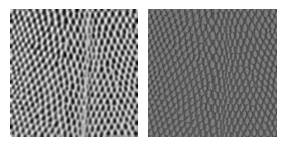

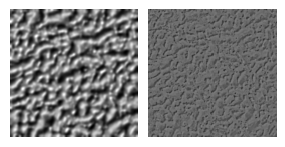

In [26]:
pt.imshow(numpy(yA).squeeze(), vrange='auto1', title=None);
pt.imshow(numpy(yB).squeeze(), vrange='auto1', title=None);

In [27]:
nsmpl = 11

moog = po.synth.Geodesic(imgA, imgB, nsmpl, model)

In [28]:
moog.parameters

<bound method Module.parameters of Geodesic(
  (squish): Tanh()
  (model): Front_End(
    (softplus): Softplus(beta=1, threshold=20)
  )
  (diff): Conv3d(1, 1, kernel_size=(2, 1, 1), stride=(1, 1, 1), bias=False)
  (blur): Conv3d(1, 1, kernel_size=(2, 1, 1), stride=(2, 1, 1), bias=False)
)>

In [34]:
moog.analyze(torch.tensor(imgA).unsqueeze(0)).shape

/Users/pe/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([3, 2, 128, 128])

In [35]:
moog.n_steps

11

In [29]:
max_iter = 200
learning_rate = .01

losses = moog.synthesize(max_iter, learning_rate)

iter 1 / 200 	loss 334.2974 	time 3.143 	grad norm 11159.475
iter 2 / 200 	loss 325.5115 	time 3.084 	grad norm 4159.95
iter 3 / 200 	loss 315.9404 	time 3.119 	grad norm 428567.438
iter 4 / 200 	loss 311.7607 	time 3.12 	grad norm 16237.906
iter 5 / 200 	loss 310.9053 	time 3.129 	grad norm 2329.96
iter 6 / 200 	loss 302.535 	time 3.123 	grad norm 10687.465


KeyboardInterrupt: 

In [ ]:
# TODO

# compare losses
# Haar
# temporal coarse to fine
# w/ w/o acc jerk

# compute the argmin
# and substract it from loss so that 0 is meaningfull
# argmin = nsmpl * ((output[-1] - output[0]) / nsmpl) ** 2

# with torch.autograd.profiler.profile() as prof:
# print(prof)


In [33]:
plt.semilogy(moog.losses.numpy())

AttributeError: 'Geodesic' object has no attribute 'losses'

In [38]:
geodesic  = numpy(moog.gamma)
pixelfade = numpy(moog.pixelfade)

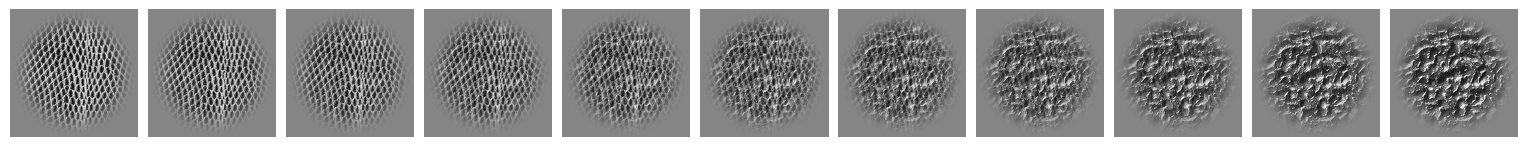

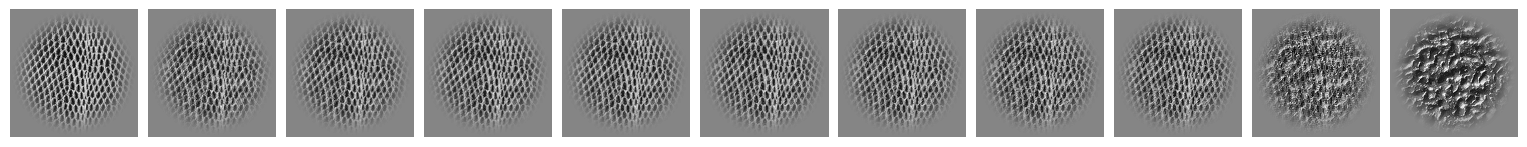

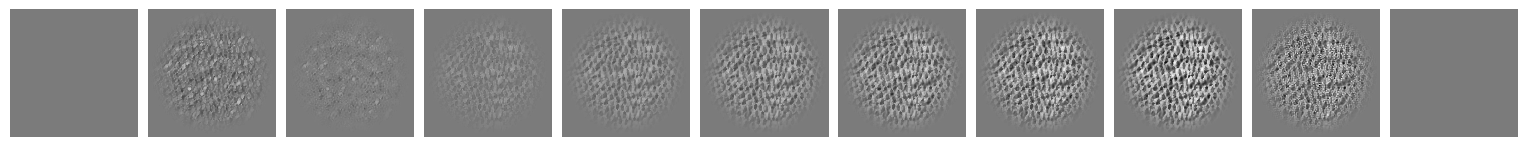

In [39]:
pt.imshow(pixelfade, vrange='auto1', title=None);
pt.imshow(geodesic, vrange='auto1', title=None);
pt.imshow(geodesic - pixelfade, vrange='auto1', title=None);

In [40]:
pt.animshow(geodesic - pixelfade)

In [41]:
# forth = pt.animshow(geodesic)
# back  = pt.animshow(geodesic[::-1])

# forth
# back

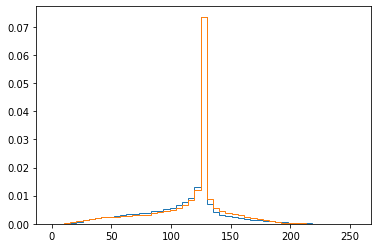

In [42]:
lin = np.linspace(0,255)
plt.hist(pixelfade.flatten(), bins=lin, density=True, histtype='step');
plt.hist(geodesic.flatten(),  bins=lin, density=True, histtype='step');

In [43]:
diff = geodesic - pixelfade
diff.shape

(11, 128, 128)

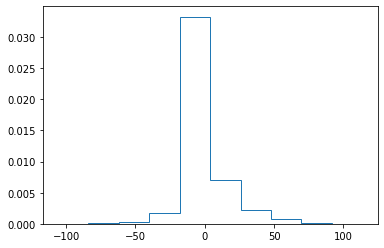

In [44]:
plt.hist(diff.flatten(), density=True, histtype='step');

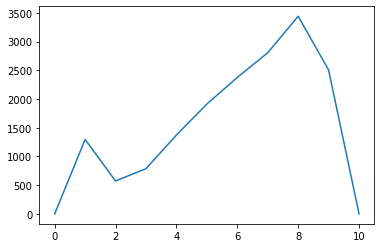

In [46]:
plt.plot(np.linalg.norm(diff.reshape((nsmpl, -1)), axis=1))

In [47]:
g = geodesic.reshape((nsmpl,-1))
p = pixelfade.reshape((nsmpl,-1))

In [48]:
angles = []
for t in range(params.nsmpl):
    angles.append(np.inner(g[t], p[t]) / (np.linalg.norm(p[t]) * np.linalg.norm(g[t])))

NameError: name 'params' is not defined

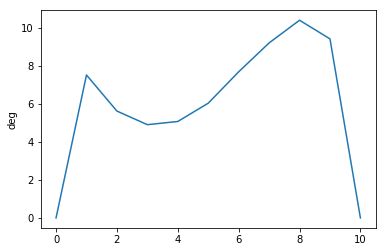

In [81]:
plt.plot(np.arccos(angles) / np.pi * 180)
plt.ylabel('deg')
plt.show()

# plt.plot(1 - abs(np.array(angles)))
# plt.ylim((0,1))

In [ ]:
# 

In [32]:
g = np.array(moog.grads).reshape(params.maxiter,-1)

AttributeError: 'Geodesic' object has no attribute 'grads'

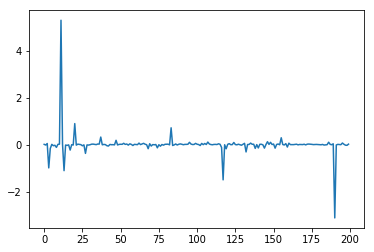

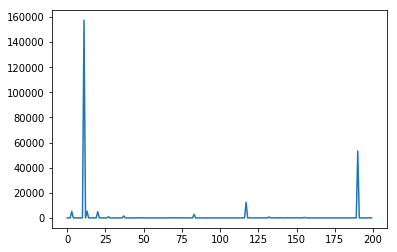

In [49]:
plt.plot(np.mean(g,axis=1))
plt.show()
plt.plot(np.var(g,axis=1))
plt.show()


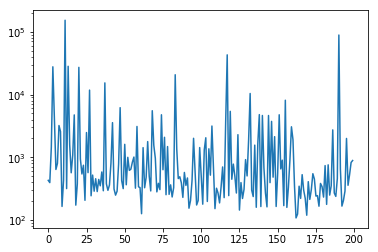

In [50]:
plt.semilogy(np.linalg.norm(g,axis=1))

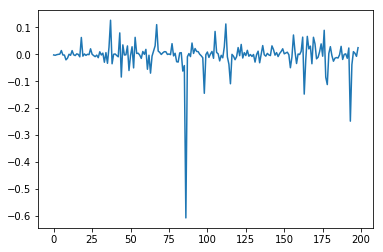

In [51]:
plt.plot([g[i,:].dot(g[i+1,:]) / (np.linalg.norm(g[i,:])* np.linalg.norm(g[i+1,:]))
          for i in range(params.maxiter-1)])